아래 Kernel의 전처리를 기반으로 하였습니다.<br>
https://www.kaggle.com/chocozzz/house-price-prediction-eda

캐글을 하다보면 Discussion에서 **Stacking, oof ** 같은 용어가 많이 보입니다.<br>
이 커널은 Stacking의 과정과 oof Feature를 만드는 방법에 대하여 설명합니다.<br>

Stacking 관련 읽어보면 좋은 자료<br>
https://mlwave.com/kaggle-ensembling-guide/ <br>
http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/ <br>

한국어 자료(감사합니다!)<br>
https://gentlej90.tistory.com/73 <br>
https://kweonwooj.tistory.com/36



### 평가 Metric은 RMSE
$$ \sqrt{\frac{1}{N}\sum(y_t - y_pr)^2} $$

### Data fields
* ID : 집을 구분하는 번호
* date : 집을 구매한 날짜
* **<font color='blue'>price : 집의 가격(Target variable)</font>**
* bedrooms : 침실의 수
* bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
* sqft_living : 주거 공간의 평방 피트(면적)
* sqft_lot : 부지의 평방 피트(면적)
* floors : 집의 층 수
* waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
* view : 집이 얼마나 좋아 보이는지의 정도
* condition : 집의 전반적인 상태
* grade : King County grading 시스템 기준으로 매긴 집의 등급
* sqft_above : 지하실을 제외한 평방 피트(면적)
* sqft_basement : 지하실의 평방 피트(면적)
* yr_built : 지어진 년도
* yr_renovated : 집을 재건축한 년도
* zipcode : 우편번호
* lat : 위도
* long : 경도
* sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
* sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [1]:
# Loading packages
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import time
from datetime import datetime, timedelta,date

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler

### Utility Function

In [2]:
def check_train_test_diff(train, test, col):
    ratio_df = pd.concat([train[col].value_counts()/train.shape[0], test[col].value_counts()/test.shape[0]], axis=1)
    ratio_df.columns = ['train','test']
    ratio_df['diff'] = ratio_df['train'] - ratio_df['test']
    return ratio_df

In [3]:
def category_feature_distribution(train, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        sns.distplot(np.log1p(train.loc[train[col]==c, target]), ax=ax[0])
    ax[0].legend(sorted(train[col].unique()))
    ax[0].set_title(f'{col} {target} distribution')

    sns.boxplot(x=col, y=target, data=df_train, ax=ax[1])
    ax[1].set_title(f'{col} vs {target}')
    
    plt.show()

In [4]:
def continous_feature_distribution(train, test, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    sns.distplot(train[col], ax=ax[0])
    sns.distplot(test[col], ax=ax[0])
    ax[0].set_title(f'{col} - train/test distribution')
    
    sns.scatterplot(x=col, y=target, data=train, ax=ax[1])
    ax[1].set_title(f'{col} - {target} scatterplot')
    
    plt.show()

In [5]:
def scatter_quantile_graph(frame, col1, col2):
    col1_quantile = np.arange(0,1.1,0.1)
    col2_quantile = np.arange(0,1.1,0.1)

    for quantile_value in frame[col1].quantile(col1_quantile):
        plt.axvline(quantile_value, color='red', alpha=0.3)
    for quantile_value in frame[col2].quantile(col2_quantile):
        plt.axhline(quantile_value, color='blue', alpha=0.3)
        
    sns.scatterplot(col1, col2, hue='price',data=frame)
    
    plt.title('{} - {}'.format(col1,col2))
    plt.show()

In [6]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [7]:
from functools import wraps
def time_decorator(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        print("\nStartTime: ", datetime.now() + timedelta(hours=9))
        start_time = time.time()
        
        df = func(*args, **kwargs)
        
        print("EndTime: ", datetime.now() + timedelta(hours=9))  
        print("TotalTime: ", time.time() - start_time)
        return df
        
    return wrapper

class SklearnWrapper(object):
    def __init__(self, clf, params=None, **kwargs):
        #if isinstance(SVR) is False:
        #    params['random_state'] = kwargs.get('seed', 0)
        self.clf = clf(**params)
        self.is_classification_problem = True
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        if len(np.unique(y_train)) > 30:
            self.is_classification_problem = False
            
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        if self.is_classification_problem is True:
            return self.clf.predict_proba(x)[:,1]
        else:
            return self.clf.predict(x)   
    
class XgbWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
    
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        need_cross_validation = True
       
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
            
            print(train_round)
            self.clf = xgb.train(self.param, dtrain, train_round)
            del dtrain
        else:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent=True)
            dvalid = xgb.DMatrix(x_cross, label=y_cross, silent=True)
            watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

            self.clf = xgb.train(self.param, dtrain, self.num_rounds, watchlist, feval=self.eval_function,
                                 early_stopping_rounds=self.early_stopping,
                                 verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)

    def predict(self, x):
        return self.clf.predict(xgb.DMatrix(x), ntree_limit=self.best_round)

    def get_params(self):
        return self.param    
    
class LgbmWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
        
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        """
        x_cross or y_cross is None
        -> model train limted num_rounds
        
        x_cross and y_cross is Not None
        -> model train using validation set
        """
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = lgb.Dataset(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
                
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=train_round)
            del dtrain   
        else:
            dtrain = lgb.Dataset(x_train, label=y_train, silent=True)
            dvalid = lgb.Dataset(x_cross, label=y_cross, silent=True)
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=self.num_rounds, valid_sets=[dtrain, dvalid],
                                  feval=self.eval_function, early_stopping_rounds=self.early_stopping,
                                  verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)
            del dtrain, dvalid
            
        gc.collect()
    
    def predict(self, x):
        return self.clf.predict(x, num_iteration=self.clf.best_iteration)
    
    def plot_importance(self):
        lgb.plot_importance(self.clf, max_num_features=50, height=0.7, figsize=(10,30))
        plt.show()
        
    def get_params(self):
        return self.param
    
    
@time_decorator
def get_oof(clf, x_train, y_train, x_test, eval_func, **kwargs):
    nfolds = kwargs.get('NFOLDS', 5)
    kfold_shuffle = kwargs.get('kfold_shuffle', True)
    kfold_random_state = kwargs.get('kfold_random_state', 0)
    stratified_kfold_ytrain = kwargs.get('stratifed_kfold_y_value', None)
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    kf_split = None
    if stratified_kfold_ytrain is None:
        kf = KFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train)
    else:
        kf = StratifiedKFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train, stratified_kfold_ytrain)
        
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))

    cv_sum = 0
    
    # before running model, print model param
    # lightgbm model and xgboost model use get_params()
    try:
        if clf.clf is not None:
            print(clf.clf)
    except:
        print(clf)
        print(clf.get_params())

    for i, (train_index, cross_index) in enumerate(kf_split):
        x_tr, x_cr = None, None
        y_tr, y_cr = None, None
        if isinstance(x_train, pd.DataFrame):
            x_tr, x_cr = x_train.iloc[train_index], x_train.iloc[cross_index]
            y_tr, y_cr = y_train.iloc[train_index], y_train.iloc[cross_index]
        else:
            x_tr, x_cr = x_train[train_index], x_train[cross_index]
            y_tr, y_cr = y_train[train_index], y_train[cross_index]

        clf.train(x_tr, y_tr, x_cr, y_cr)
        
        oof_train[cross_index] = clf.predict(x_cr)

        cv_score = eval_func(y_cr, oof_train[cross_index])
        
        print('Fold %d / ' % (i+1), 'CV-Score: %.6f' % cv_score)
        cv_sum = cv_sum + cv_score
        
        del x_tr, x_cr, y_tr, y_cr
        
    gc.collect()
    
    score = cv_sum / nfolds
    print("Average CV-Score: ", score)

    # Using All Dataset, retrain
    clf.train(x_train, y_train)
    oof_test = clf.predict(x_test)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), score

### Data load

In [8]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

In [9]:
print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


Stacking을 처음부터 하는 것은 추천드리지 않습니다. 처음에는 데이터의 특성부터 파악합니다.

In [10]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
default_check = pd.concat([df_train.isnull().sum(), df_train.dtypes, df_train.nunique(), df_train.describe().T], axis=1)
default_check.rename(columns={0:'NULL', 1:'TYPE', 2:'UNIQUE'}, inplace=True)
default_check

,NULL,TYPE,UNIQUE,count,mean,std,min,25%,50%,75%,max
bathrooms,0,float64,29,15035.0,2.115065,0.767519,0.0000,1.7500,2.2500,2.5000,8.000000e+00
bedrooms,0,int64,11,15035.0,3.369139,0.902721,0.0000,3.0000,3.0000,4.0000,1.000000e+01
condition,0,int64,5,15035.0,3.406651,0.646505,1.0000,3.0000,3.0000,4.0000,5.000000e+00
date,0,object,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floors,0,float64,6,15035.0,1.498071,0.538522,1.0000,1.0000,1.5000,2.0000,3.500000e+00
grade,0,int64,12,15035.0,7.660725,1.179803,1.0000,7.0000,7.0000,8.0000,1.300000e+01
id,0,int64,15035,15035.0,7517.000000,4340.374984,0.0000,3758.5000,7517.0000,11275.5000,1.503400e+04
lat,0,float64,4692,15035.0,47.560721,0.138164,47.1559,47.4727,47.5719,47.6783,4.777760e+01
long,0,float64,716,15035.0,-122.213677,0.141294,-122.5190,-122.3280,-122.2310,-122.1260,-1.213150e+02
price,0,float64,3263,15035.0,540682.653143,371524.660390,78000.0000,322000.0000,450000.0000,645000.0000,7.700000e+06


Target 값의 분포를 확인합니다. 원본 값이 얼마나 치우쳐져 있는지, log변환했을 때 어느정도로 정규성을 띄는지 등등<br>
또한 혹시 Leak이 있는지 확인합니다. ID Leak이 있다면 targer값이 크기가 오름차순/내림차순의 성향이나 특정 패턴을 가질 수 있습니다.<br>

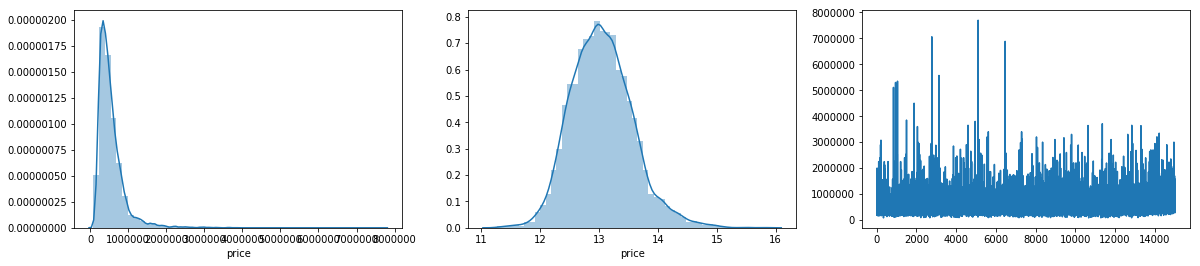

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(df_train['price'], ax=ax[0])
sns.distplot(np.log1p(df_train['price']), ax=ax[1])
df_train['price'].plot(ax=ax[2])
plt.show()

모든 변수를 살펴봐야 합니다. 살펴보면서 특징을 찾습니다. <br>
꼭 확인해야 할 것은 아래와 같습니다.
* Train / Test 의 분포 차이 <br>
-> Public LB, Private LB의 차이가 발생할 수 있는 요인일 수 있습니다.
* Target 값과의 분포
* 시간에 따른 Target 분포의 변화

### 집의 특성들
['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

In [13]:
from IPython.display import display
for col in ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']:
    print(col)
    display(check_train_test_diff(df_train, df_test, col))

bedrooms


,train,test,diff
0,0.000266,0.001391,-0.001125
1,0.008846,0.009586,-0.000740
2,0.128434,0.126005,0.002429
3,0.454606,0.452845,0.001761
4,0.319056,0.318955,0.000101
5,0.073695,0.074830,-0.001135
6,0.012504,0.012832,-0.000328
7,0.001463,0.002474,-0.001010
8,0.000665,0.000464,0.000201
9,0.000333,0.000155,0.000178


bathrooms


,train,test,diff
0.00,0.000266,0.000928,-0.000662
0.50,0.000200,0.000155,0.000045
0.75,0.002993,0.004020,-0.001027
1.00,0.177918,0.177025,0.000893
1.25,0.000333,0.000618,-0.000286
1.50,0.067110,0.066327,0.000784
1.75,0.140472,0.141775,-0.001303
2.00,0.090256,0.087199,0.003058
2.25,0.095311,0.092919,0.002392
2.50,0.249285,0.249845,-0.000560


floors


,train,test,diff
1.0,0.489591,0.502628,-0.013037
2.0,0.386432,0.371985,0.014447
1.5,0.088460,0.087353,0.001107
3.0,0.027735,0.029994,-0.002259
2.5,0.007516,0.007421,0.000095
3.5,0.000266,0.000618,-0.000352


waterfront


,train,test,diff
0,0.992883,0.991342,0.001541
1,0.007117,0.008658,-0.001541


view


,train,test,diff
0,0.901097,0.902443,-0.001345
1,0.016029,0.014069,0.001960
2,0.044230,0.045918,-0.001688
3,0.024809,0.020717,0.004091
4,0.013834,0.016852,-0.003018


condition


,train,test,diff
3,0.651347,0.644403,0.006944
4,0.263119,0.262987,0.000132
5,0.076821,0.082560,-0.005740
2,0.007316,0.008813,-0.001496
1,0.001397,0.001237,0.000160


grade


,train,test,diff
1,0.000067,NaN,NaN
3,0.000133,0.000155,-0.000022
4,0.001530,0.000928,0.000602
5,0.011573,0.009586,0.001987
6,0.093515,0.094465,-0.000950
7,0.414233,0.417594,-0.003361
8,0.279814,0.284941,-0.005127
9,0.123379,0.116574,0.006805
10,0.051945,0.054113,-0.002167
11,0.019155,0.016698,0.002458


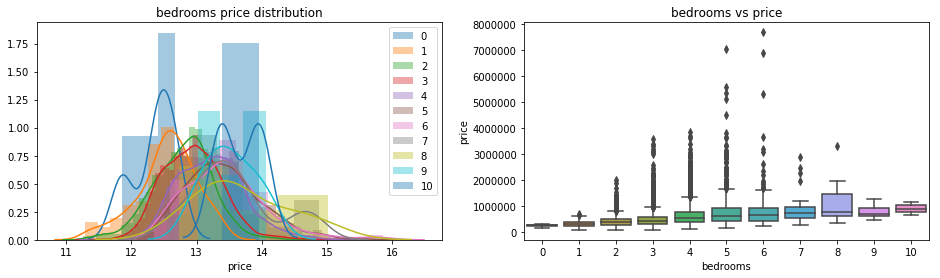

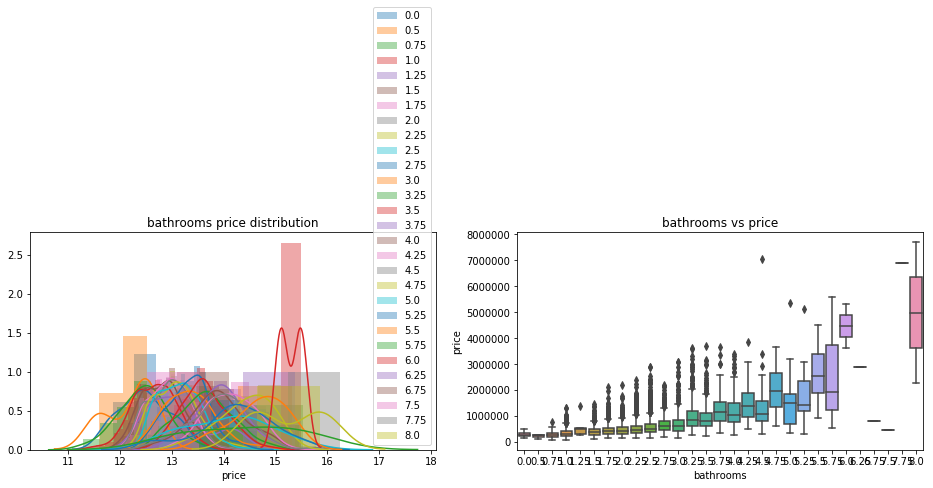

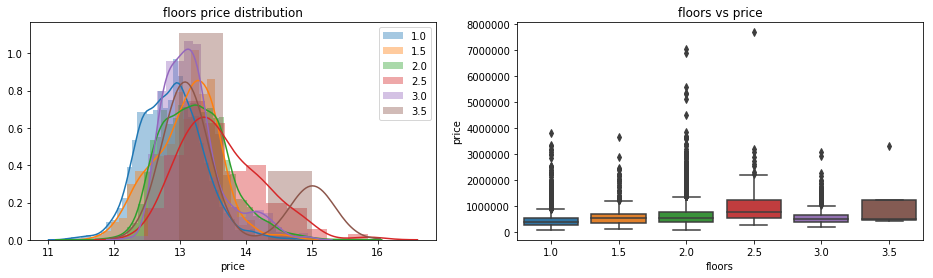

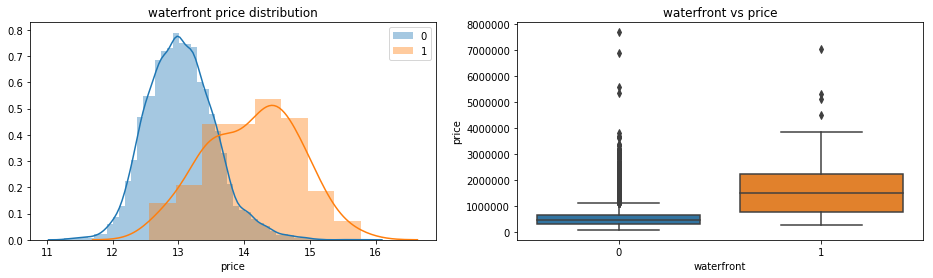

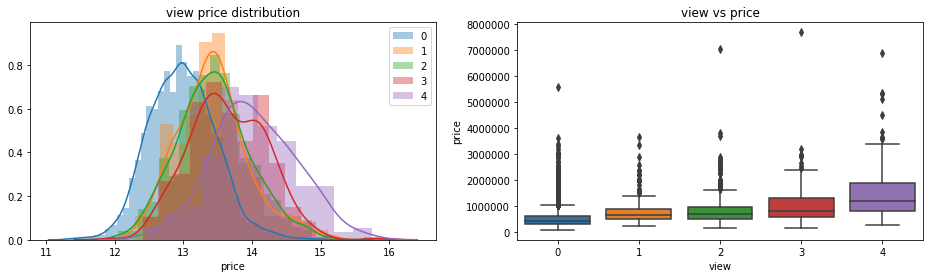

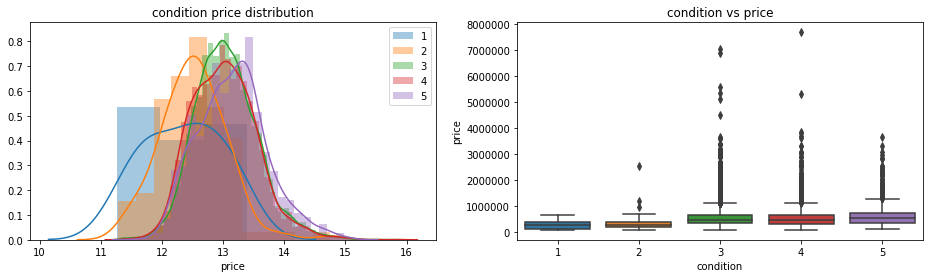

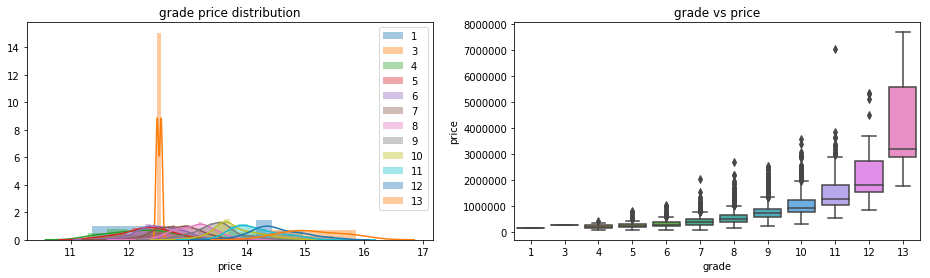

In [14]:
for col in ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']:
    category_feature_distribution(df_train, col)

### 시간

train, test dataset 시간이 비슷함

In [15]:
df_train['date'] = pd.to_datetime(df_train['date'])
print(df_train['date'].min(), df_train['date'].max())

df_test['date'] = pd.to_datetime(df_test['date'])
print(df_test['date'].min(), df_test['date'].max())

2014-05-02 00:00:00 2015-05-14 00:00:00
2014-05-02 00:00:00 2015-05-27 00:00:00


원래 데이터는 train, test가 날짜로 정렬된 하나의 데이터?

In [16]:
print("Train")
display(df_train.sort_values('date').head())
print("Test")
display(df_test.sort_values('date').head())

Train


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2648,2648,2014-05-02,463000.0,3,1.75,1710,7320,1.0,0,0,3,7,1710,0,1948,0,98155,47.7512,-122.281,2260,8839
4734,4734,2014-05-02,750000.0,3,1.75,2240,10578,2.0,0,0,5,8,1550,690,1923,0,98115,47.6954,-122.292,1570,10578
754,754,2014-05-02,550000.0,4,2.50,1940,10500,1.0,0,0,4,7,1140,800,1976,0,98052,47.6830,-122.114,2200,10500
7160,7160,2014-05-02,382500.0,4,1.75,1560,8700,1.0,0,0,4,7,1560,0,1967,0,98034,47.7274,-122.181,2080,8000
4002,4002,2014-05-02,419000.0,3,1.50,1570,6700,1.0,0,0,4,7,1570,0,1956,0,98007,47.6022,-122.134,1570,7300


Test


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4999,20034,2014-05-02,3,2.25,1970,35100,2.0,0,0,4,9,1970,0,1977,0,98027,47.4635,-121.991,2340,35100
1719,16754,2014-05-02,4,2.50,2200,9397,2.0,0,0,3,8,2200,0,1987,0,98001,47.3406,-122.269,2310,9176
5938,20973,2014-05-02,3,2.50,1770,1235,3.0,0,0,3,8,1600,170,2007,0,98103,47.6965,-122.342,1680,1203
6177,21212,2014-05-02,4,2.50,3310,6500,2.0,0,0,3,8,3310,0,2012,0,98065,47.5150,-121.870,2380,5000
4608,19643,2014-05-02,3,2.50,1770,2875,2.0,0,0,3,8,1770,0,1990,0,98116,47.5631,-122.397,1770,3833


이게 일직선이 아니였다면 date Leak<br>
date로 train, test를 정렬하고 새로운 id를 매겨 dateid feature 사용 가능했을 것으로 추측

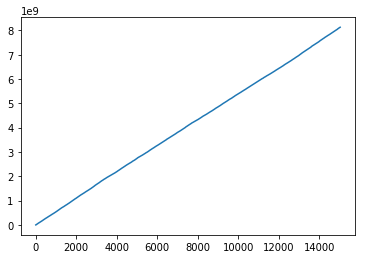

In [17]:
plt.plot(df_train.sort_values('date')['price'].cumsum().values)

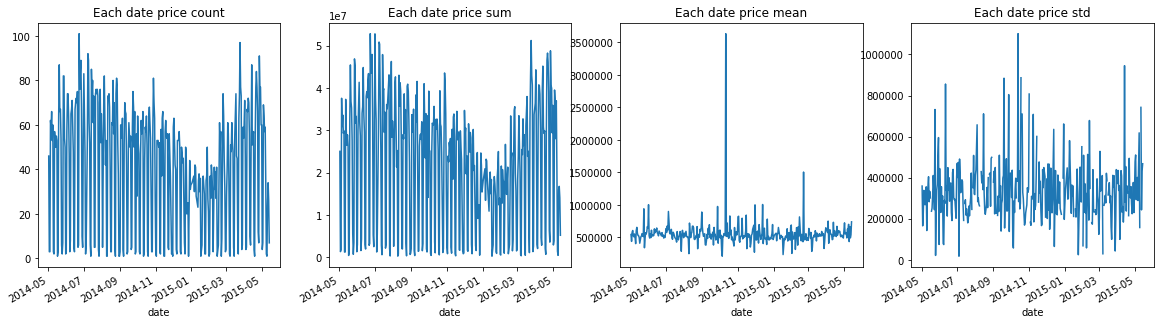

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
df_train.groupby('date')['price'].count().plot(ax=ax[0])
ax[0].set_title('Each date price count')
df_train.groupby('date')['price'].sum().plot(ax=ax[1])
ax[1].set_title('Each date price sum')
df_train.groupby('date')['price'].mean().plot(ax=ax[2])
ax[2].set_title('Each date price mean')
df_train.groupby('date')['price'].std().plot(ax=ax[3])
ax[3].set_title('Each date price std')
plt.show()

갑자기 튄 price mean

In [19]:
df_train.loc[df_train['date']==np.argmax(df_train.groupby('date')['price'].mean())]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13311,13311,2014-10-11,3635000.0,5,6.0,5490,19897,2.0,0,0,3,12,5490,0,2005,0,98039,47.6165,-122.236,2910,17600


일별 판매 횟수가 test가 적지만, 분포는 비슷한 것을 볼 수 있습니다.

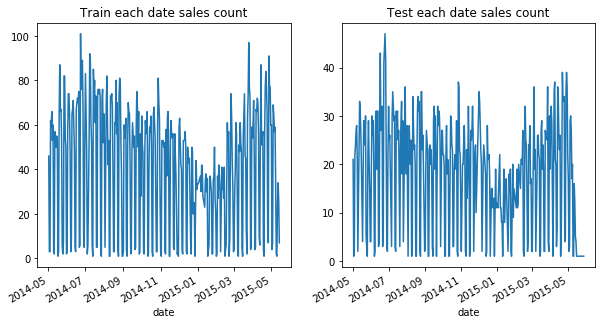

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
df_train.groupby('date')['id'].count().plot(ax=ax[0])
ax[0].set_title('Train each date sales count')
df_test.groupby('date')['id'].count().plot(ax=ax[1])
ax[1].set_title('Test each date sales count')
plt.show()

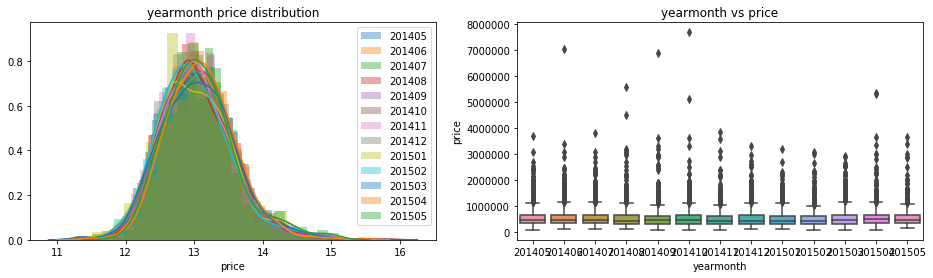

In [21]:
df_train['yearmonth'] = df_train['date'].dt.year*100 + df_train['date'].dt.month
category_feature_distribution(df_train,'yearmonth')


### 면적들


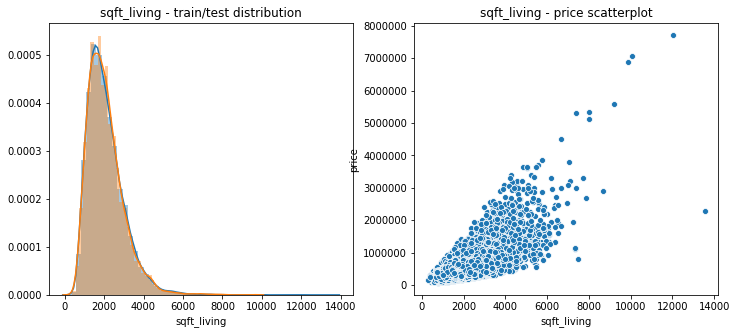

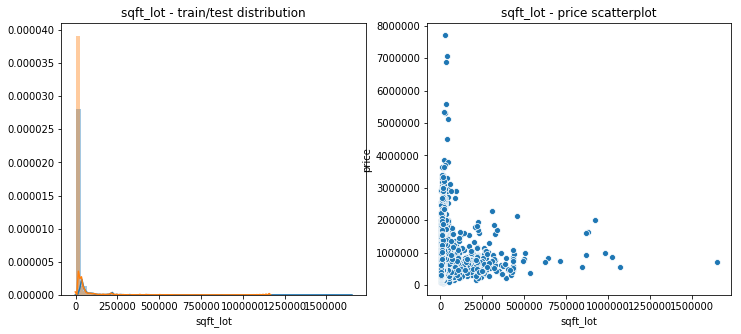

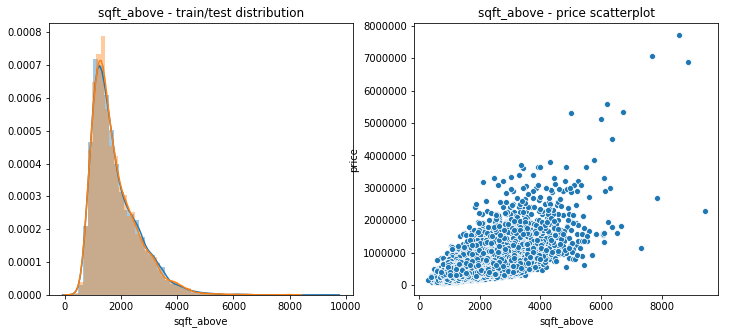

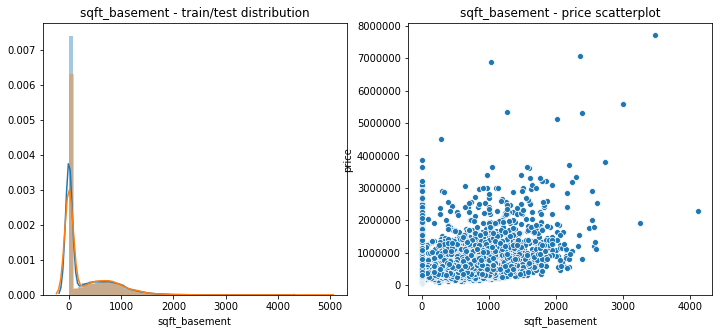

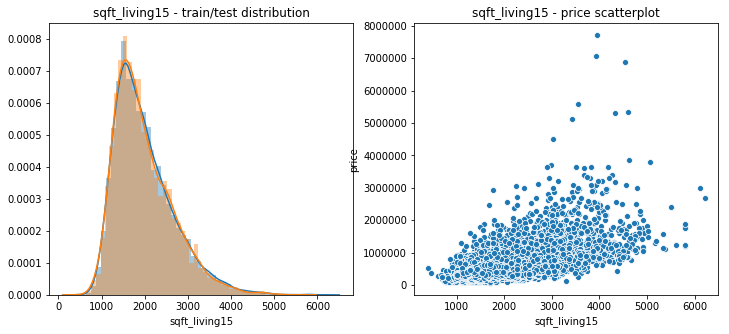

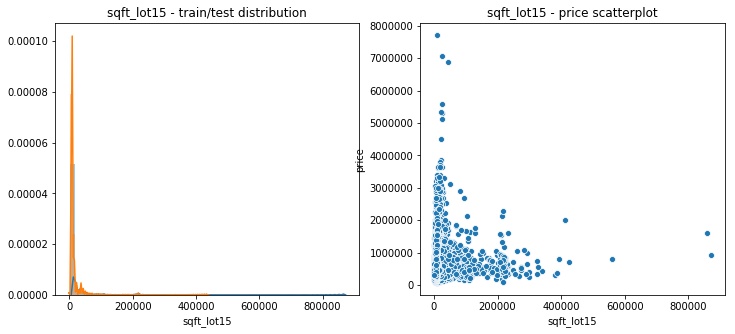

In [22]:
area_feature = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
for col in area_feature:
    continous_feature_distribution(df_train, df_test, col)

### 위치

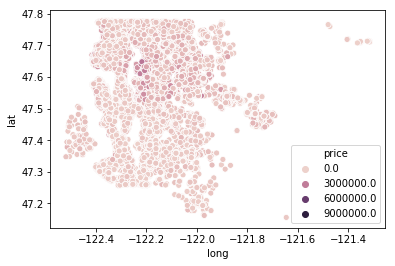

In [23]:
sns.scatterplot('long','lat',hue='price',data=df_train)

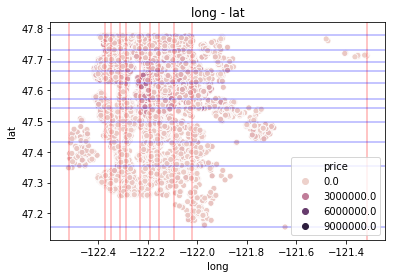

In [24]:
scatter_quantile_graph(df_train, 'long', 'lat')

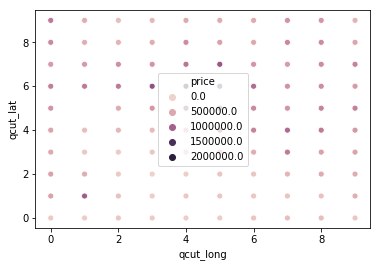

In [25]:
qcut_count = 10
df_train['qcut_long'] = pd.qcut(df_train['long'], qcut_count, labels=range(qcut_count))
df_train['qcut_lat'] = pd.qcut(df_train['lat'], qcut_count, labels=range(qcut_count))
temp = df_train.groupby(['qcut_long','qcut_lat'])['price'].mean().reset_index()
sns.scatterplot('qcut_long','qcut_lat', hue='price', data=temp);
del df_train['qcut_long'], df_train['qcut_lat']

### Feature Preprocessing

In [26]:
df_train = df_train.loc[df_train['bedrooms']<10]

#### 2.2 정규화
코드는 다음의 링크를 활용하였습니다. https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline

In [27]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [28]:
for df in [df_train,df_test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

https://www.kaggle.com/chocozzz/house-price-prediction-eda

In [29]:
def feature_processing(df):
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['grade_condition'] = df['grade'] * df['condition']
    df['sqft_total'] = df['sqft_living'] + df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
   
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    
    df['roombybathroom'] = df['bedrooms'] / df['bathrooms']
    df['sqft_total_by_lot'] = (df['sqft_living'] + df['sqft_above'] + df['sqft_basement'])/df['sqft_lot']
    
    qcut_count = 10
    df['qcut_long'] = pd.qcut(df['long'], qcut_count, labels=range(qcut_count))
    df['qcut_lat'] = pd.qcut(df['lat'], qcut_count, labels=range(qcut_count))
    df['qcut_long'] = df['qcut_long'].astype(int)
    df['qcut_lat'] = df['qcut_lat'].astype(int)

    df['date'] = pd.to_datetime(df['date'])
    df['yearmonth'] = df['date'].dt.year*100 + df['date'].dt.month
    df['date'] = df['date'].astype('int')
    return df

In [30]:
all_df = pd.concat([df_train, df_test])
all_df = feature_processing(all_df)

In [31]:
df_test = all_df.loc[all_df['price'].isnull()]
df_train = all_df.loc[all_df['price'].notnull()]

In [32]:
group_df = groupby_helper(df_train, 'grade', 'price', ['mean'])
df_train = df_train.merge(group_df, on='grade', how='left')
df_test = df_test.merge(group_df, on='grade', how='left')

group_df = groupby_helper(df_train, 'bedrooms', 'price', ['mean'])
df_train = df_train.merge(group_df, on='bedrooms', how='left')
df_test = df_test.merge(group_df, on='bedrooms', how='left')

group_df = groupby_helper(df_train, 'bathrooms', 'price', ['mean'])
df_train = df_train.merge(group_df, on='bathrooms', how='left')
df_test = df_test.merge(group_df, on='bathrooms', how='left')

grade price ['mean']
bedrooms price ['mean']
bathrooms price ['mean']


In [33]:
train_columns = [col for col in df_train.columns if col not in ['id','price']]

x_train = df_train.copy()
y_train = np.log1p(df_train['price'])
del x_train['price']
x_train.loc[np.isinf(x_train['roombybathroom']),'roombybathroom'] = -1


x_test = df_test.copy()
x_test.loc[np.isinf(x_test['roombybathroom']),'roombybathroom'] = -1

In [34]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

In [35]:
lgb_param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 4950,
    'eta': 0.0123,
    'gamma':0,
    'max_depth':3,
    'reg_alpha':0.00006,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'silent': 1,
}

ridge_params = {'alpha':0.0001, 'normalize':True, 'max_iter':1e7, 'random_state':0}
lasso_params = {'alpha':0.0005, 'normalize':True, 'max_iter':1e7, 'random_state':0}
elastic_params = {'alpha':0.001, 'normalize':True, 'max_iter':1e3, 'random_state':0, 'l1_ratio':0.8}
svr_param = {'C':20, 'epsilon':0.008, 'gamma':0.0003}
gbr_param = {'n_estimators':3000, 'learning_rate':0.05, 'max_depth':4, 'max_features':'sqrt', 'min_samples_leaf':15, 'min_samples_split':10, 'loss':'huber', 'random_state':0 }

In [36]:
xgb_model = XgbWrapper(params=xgb_params, num_rounds = 10000, ealry_stopping=100,
                                   verbose_eval=100)

lgb_model = LgbmWrapper(params=lgb_param, num_rounds = 10000, ealry_stopping=100,
                                   verbose_eval=100)

ridge_model = SklearnWrapper(Ridge, params=ridge_params)
lasso_model = SklearnWrapper(Lasso, params=lasso_params)
elastic_model = SklearnWrapper(ElasticNet, params=lasso_params)
svr_model = SklearnWrapper(SVR, params=svr_param)
gbr_model = SklearnWrapper(GradientBoostingRegressor, params=gbr_param)

In [37]:
x_train_rb = x_train.copy()
x_test_rb = x_test.copy()
rb = RobustScaler()
x_train_rb[train_columns] = rb.fit_transform(x_train_rb[train_columns].fillna(-1))
x_test_rb[train_columns] = rb.transform(x_test_rb[train_columns].fillna(-1))

In [38]:
ridge_train, ridge_test, ridge_cv_score = get_oof(ridge_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

lasso_train, lasso_test, lasso_cv_score = get_oof(lasso_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

elastic_train, elastic_test, lasso_cv_score = get_oof(elastic_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

svr_train, svr_test, lasso_cv_score = get_oof(svr_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

gbr_train, gbr_test, lasso_cv_score = get_oof(gbr_model, x_train[train_columns].fillna(-1), y_train, x_test[train_columns].fillna(-1), 
                            rmse, NFOLDS=5, kfold_random_state=4950)

xgb_train, xgb_test, xgb_cv_score = get_oof(xgb_model, x_train[train_columns], y_train, x_test[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

lgb_train, lgb_test, lgb_cv_score = get_oof(lgb_model, x_train[train_columns], y_train, x_test[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)


StartTime:  2019-03-25 20:38:13.220814
Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000000.0,
   normalize=True, random_state=0, solver='auto', tol=0.001)

StartTime:  2019-03-25 20:38:13.226025
EndTime:  2019-03-25 20:38:13.244356
TotalTime:  0.018370628356933594
Fold 1 /  CV-Score: 180042.647025

StartTime:  2019-03-25 20:38:13.249257
EndTime:  2019-03-25 20:38:13.255787
TotalTime:  0.006534099578857422
Fold 2 /  CV-Score: 178282.566162

StartTime:  2019-03-25 20:38:13.260277
EndTime:  2019-03-25 20:38:13.266498
TotalTime:  0.006225109100341797
Fold 3 /  CV-Score: 163308.296911

StartTime:  2019-03-25 20:38:13.271019
EndTime:  2019-03-25 20:38:13.277343
TotalTime:  0.006318330764770508
Fold 4 /  CV-Score: 184048.772413

StartTime:  2019-03-25 20:38:13.281681
EndTime:  2019-03-25 20:38:13.288006
TotalTime:  0.006323814392089844
Fold 5 /  CV-Score: 189741.245483
Average CV-Score:  179084.70559914404

StartTime:  2019-03-25 20:38:13.362348
EndTime:  2019-03-25 20:38:

In [39]:
x_train_second_layer = np.concatenate((lgb_train, xgb_train, lasso_train, 
                                       ridge_train, elastic_train, svr_train, 
                                       gbr_train), axis=1)

x_test_second_layer = np.concatenate((lgb_test, xgb_test, lasso_test, 
                                      ridge_test, elastic_test, svr_test, 
                                      gbr_test), axis=1)

x_train = pd.concat([df_train['id'], pd.DataFrame(x_train_second_layer)], axis=1)
x_test = pd.concat([df_test['id'], pd.DataFrame(x_test_second_layer)], axis=1)

x_train.to_csv('train_oof.csv', index=False)
x_test.to_csv('test_oof.csv', index=False)
del x_train['id']
del x_test['id']

https://www.kaggle.com/chocozzz/house-price-prediction-eda

In [40]:
lgb_meta_param = {'num_leaves': 15,
         'objective':'regression',
         'max_depth': 5,
         'learning_rate': 0.015,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
         
#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    trn_data = lgb.Dataset(x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(x_train.iloc[val_idx], label=y_train.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(lgb_meta_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(x_train.iloc[val_idx], num_iteration=clf.best_iteration)
   
    #predictions
    predictions += clf.predict(x_test, num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_train))
print(cv)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[379]	training's rmse: 0.151875	valid_1's rmse: 0.160157
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.153385	valid_1's rmse: 0.160844
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 0.15393	valid_1's rmse: 0.155517
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.151791	valid_1's rmse: 0.156657
Early stopping, best iteration is:
[482]	training's rmse: 0.151952	valid_1's rmse: 0.156637
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.150947	valid_1's rmse: 0.159977
Early stopping, best iteration is:
[405]	training's rmse: 0.152008	valid_1's rmse: 0.159768
0.15859850427711752


In [41]:
submission = pd.DataFrame({'id': df_test['id'], 'price': np.expm1(predictions)})
submission.to_csv('submission.csv', index=False)